EECNN — Emotion Recognition on RAF-DB

Author: Ruban Sampath

Purpose: Train, evaluate, and analyze the EECNN model for 7-class facial emotion recognition on RAF-DB.

Imports

In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
from tqdm import tqdm
from PIL import Image
import pandas as pd

Drive Mount

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Dataset Setup

In [ ]:
DATA_DIR = "/content/drive/MyDrive/Computer Vision Project/dataset/raf-db/DATASET"

train_path = os.path.join(DATA_DIR, "train")
test_path  = os.path.join(DATA_DIR, "test")

print("Train Path:", train_path)
print("Test Path:", test_path)

Train Path: /content/drive/MyDrive/Computer Vision Project/dataset/raf-db/DATASET/train
Test Path: /content/drive/MyDrive/Computer Vision Project/dataset/raf-db/DATASET/test


Transforms

In [ ]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

Load Datasets

In [ ]:
train_dataset = datasets.ImageFolder(root=train_path, transform=train_transform)
test_dataset  = datasets.ImageFolder(root=test_path,  transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
test_loader  = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)

print("Classes:", train_dataset.classes)
print("Class mapping:", train_dataset.class_to_idx)

Classes: ['1', '2', '3', '4', '5', '6', '7']
Class mapping: {'1': 0, '2': 1, '3': 2, '4': 3, '5': 4, '6': 5, '7': 6}


Device

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


EECNN

In [ ]:
class ChannelAttention(nn.Module):
    def __init__(self, in_channels, reduction=16):
        super(ChannelAttention, self).__init__()
        self.fc1 = nn.Conv2d(in_channels, in_channels // reduction, 1, bias=False)
        self.fc2 = nn.Conv2d(in_channels // reduction, in_channels, 1, bias=False)
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.fc2(self.relu(self.fc1(self.avg_pool(x))))
        max_out = self.fc2(self.relu(self.fc1(self.max_pool(x))))
        out = avg_out + max_out
        return self.sigmoid(out) * x


class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        self.conv = nn.Conv2d(2, 1, kernel_size, padding=kernel_size//2, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        out = torch.cat([avg_out, max_out], dim=1)
        out = self.conv(out)
        return self.sigmoid(out) * x


class CBAM(nn.Module):
    def __init__(self, in_channels):
        super(CBAM, self).__init__()
        self.channel_att = ChannelAttention(in_channels)
        self.spatial_att = SpatialAttention()

    def forward(self, x):
        x = self.channel_att(x)
        x = self.spatial_att(x)
        return x


class EECNN(nn.Module):
    def __init__(self, num_classes=7):
        super(EECNN, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, 3, 1, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 128, 3, 1, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(128, 256, 3, 1, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(256, 512, 3, 1, 1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.attention = CBAM(512)

        self.fc1 = nn.Linear(14*14*(128+256+512), 512)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x1 = self.conv1(x)
        x2 = self.conv2(x1)
        x3 = self.conv3(x2)
        x4 = self.conv4(x3)

        x4 = self.attention(x4)

        x2_resized = F.interpolate(x2, size=(14, 14), mode='bilinear', align_corners=False)
        x3_resized = F.interpolate(x3, size=(14, 14), mode='bilinear', align_corners=False)

        fused = torch.cat([x2_resized, x3_resized, x4], dim=1)
        fused = fused.view(fused.size(0), -1)

        out = self.fc1(fused)
        out = self.dropout(out)
        out = self.fc2(out)
        return out


Training Setup

In [ ]:
model = EECNN(num_classes=7).to(device)

labels = [label for _, label in train_dataset.imgs]
weights = compute_class_weight(class_weight="balanced",
                               classes=np.unique(labels),
                               y=labels)
weights = torch.tensor(weights, dtype=torch.float).to(device)

criterion = nn.CrossEntropyLoss(weight=weights, label_smoothing=0.1)
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50)

Training Loop

In [ ]:
num_epochs = 50
best_acc = 0

train_losses, val_losses = [], []
train_accs, val_accs = [], []

save_path = "/content/drive/MyDrive/Best_Models/eecnn_rafdb_best.pth"
os.makedirs(os.path.dirname(save_path), exist_ok=True)

for epoch in range(num_epochs):
    model.train()
    correct, total, loss_sum = 0, 0, 0

    for images, labels in tqdm(train_loader, desc=f"Train Epoch {epoch+1}"):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        loss_sum += loss.item()
        _, preds = outputs.max(1)
        total += labels.size(0)
        correct += preds.eq(labels).sum().item()

    train_acc = correct / total * 100
    train_accs.append(train_acc)
    train_losses.append(loss_sum / len(train_loader))

    # -------- Validation --------
    model.eval()
    correct, total, loss_sum = 0, 0, 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            loss_sum += loss.item()
            _, preds = outputs.max(1)
            total += labels.size(0)
            correct += preds.eq(labels).sum().item()

    val_acc = correct / total * 100
    val_accs.append(val_acc)
    val_losses.append(loss_sum / len(test_loader))

    print(f"Epoch {epoch+1:02d} | Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%")

    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), save_path)
        print(f"🔥 Saved new best model (Acc: {best_acc:.2f}%)")

    scheduler.step()

Training Curves

In [ ]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.legend()
plt.title("Loss Curve")

plt.subplot(1,2,2)
plt.plot(train_accs, label="Train Acc")
plt.plot(val_accs, label="Val Acc")
plt.legend()
plt.title("Accuracy Curve")

plt.show()

valuation (Confusion Matrix + Report)

In [ ]:
model.load_state_dict(torch.load(save_path))
model.eval()

all_labels = []
all_preds  = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = outputs.max(1)

        all_labels.extend(labels.numpy())
        all_preds.extend(preds.cpu().numpy())

print(classification_report(all_labels, all_preds, target_names=train_dataset.classes))

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=train_dataset.classes,
            yticklabels=train_dataset.classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

Prediction Helper

In [ ]:
emotion_map = {
    "1": "Surprise",
    "2": "Fear",
    "3": "Disgust",
    "4": "Happiness",
    "5": "Sadness",
    "6": "Anger",
    "7": "Neutral"
}

def predict_image(img_path):

    image = Image.open(img_path).convert("RGB")
    image = val_transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(image)
        _, pred = outputs.max(1)

    # pred.item() is 0..6 → class name is "1".."7"
    class_name = test_dataset.classes[pred.item()]  # e.g., "4"
    emotion = emotion_map[class_name]
    return emotion


In [ ]:
def show_prediction(img_path):
    img = Image.open(img_path).convert("RGB")
    emotion = predict_image(img_path)
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Predicted: {emotion}")
    plt.show()

Load video_01 Labels and Create Fine-Tuning Dataset

In [ ]:
BASE = "/content/drive/MyDrive/VideoCalls/video_01"
FRAMES_DIR = f"{BASE}/frames"
LABELS_CSV = f"{BASE}/teacher_labels/labels.csv"

print("Frames path:", FRAMES_DIR)
print("CSV path:", LABELS_CSV)

Frames path: /content/drive/MyDrive/VideoCalls/video_01/frames
CSV path: /content/drive/MyDrive/VideoCalls/video_01/teacher_labels/labels.csv


In [ ]:
# Load CSV
df = pd.read_csv(LABELS_CSV)
df["label"] = df["label"].str.strip().str.lower()

# Normalize labels
normalize = {
    "angry": "angry",
    "anger": "angry",
    "disgust": "disgust",
    "fear": "fear",
    "happy": "happy",
    "happiness": "happy",
    "sad": "sad",
    "sadness": "sad",
    "surprise": "surprise",
    "neutral": "neutral"
}

df["label"] = df["label"].map(normalize)

EMOTIONS = ["angry", "disgust", "fear", "happy", "sad", "surprise", "neutral"]
label_to_id = {e: i for i, e in enumerate(EMOTIONS)}

df["label_id"] = df["label"].map(label_to_id)

print(df.head())
print("Classes:", label_to_id)


   frame_id      filename    label  label_id
0         0  face_000.jpg  neutral         6
1         1  face_001.jpg  neutral         6
2         2  face_002.jpg    happy         3
3         3  face_003.jpg    happy         3
4         4  face_004.jpg      sad         4
Classes: {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'sad': 4, 'surprise': 5, 'neutral': 6}


In [ ]:
class VideoFineTuneDataset(Dataset):
    def __init__(self, df, frames_dir, transform):
        self.df = df.reset_index(drop=True)
        self.frames_dir = frames_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.frames_dir, row["filename"])
        img = Image.open(img_path).convert("RGB")
        img = self.transform(img)
        return img, row["label_id"]


In [ ]:
fine_tune_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])


In [ ]:
fine_tune_ds = VideoFineTuneDataset(df, FRAMES_DIR, fine_tune_transform)
fine_tune_loader = DataLoader(fine_tune_ds, batch_size=32, shuffle=True)

len(fine_tune_ds)


134

In [ ]:
DEVICE = device  # using your existing device variable

EECNN_BEST_RAF = "/content/drive/MyDrive/Best_Models/eecnn_rafdb_best.pth"

eecnn_model = EECNN(num_classes=7).to(DEVICE)
state = torch.load(EECNN_BEST_RAF, map_location=DEVICE)
eecnn_model.load_state_dict(state)
eecnn_model.train()

print("Loaded pretrained RAF model!")


Loaded pretrained RAF model!


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(eecnn_model.parameters(), lr=1e-4)


In [ ]:
epochs = 12   # your sweet spot

for epoch in range(epochs):
    eecnn_model.train()

    total, correct, loss_sum = 0, 0, 0

    for imgs, labels in fine_tune_loader:
        imgs = imgs.to(DEVICE)
        labels = labels.to(DEVICE)

        optimizer.zero_grad()
        outputs = eecnn_model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        loss_sum += loss.item()
        _, preds = outputs.max(1)
        total += labels.size(0)
        correct += preds.eq(labels).sum().item()

    acc = correct / total * 100
    print(f"Epoch {epoch+1}/{epochs}  Loss={loss_sum/len(fine_tune_loader):.4f}  Acc={acc:.2f}%")


Epoch 1/12  Loss=1.7298  Acc=43.28%
Epoch 2/12  Loss=1.2107  Acc=50.75%
Epoch 3/12  Loss=1.2012  Acc=59.70%
Epoch 4/12  Loss=1.1716  Acc=71.64%
Epoch 5/12  Loss=1.0636  Acc=61.94%
Epoch 6/12  Loss=0.9462  Acc=71.64%
Epoch 7/12  Loss=0.8556  Acc=68.66%
Epoch 8/12  Loss=0.8413  Acc=72.39%
Epoch 9/12  Loss=0.7022  Acc=72.39%
Epoch 10/12  Loss=0.8446  Acc=74.63%
Epoch 11/12  Loss=0.6516  Acc=75.37%
Epoch 12/12  Loss=0.6297  Acc=75.37%


In [ ]:
FINETUNED_MODEL = "/content/drive/MyDrive/Best_Models/eecnn_video01_finetuned.pth"
torch.save(eecnn_model.state_dict(), FINETUNED_MODEL)
print("Saved fine-tuned model to:", FINETUNED_MODEL)

Saved fine-tuned model to: /content/drive/MyDrive/Best_Models/eecnn_video01_finetuned.pth


In [ ]:
EECNN_CKPT = "/content/drive/MyDrive/Best_Models/eecnn_video01_finetuned.pth"

# Create model with correct architecture (already defined above)
eecnn_model = EECNN(num_classes=7).to(device)

# Load best weights
state = torch.load(EECNN_CKPT, map_location=device)
eecnn_model.load_state_dict(state)
eecnn_model.eval()

print("Loaded EECNN best model from:", EECNN_CKPT)

Loaded EECNN best model from: /content/drive/MyDrive/Best_Models/eecnn_video01_finetuned.pth


In [ ]:
# Teacher CSV paths
BASE = "/content/drive/MyDrive/VideoCalls/video_01"
FRAMES_DIR = f"{BASE}/frames"
LABELS_CSV = f"{BASE}/teacher_labels/labels.csv"

# Load labels
df = pd.read_csv(LABELS_CSV)
df["label"] = df["label"].str.strip().str.lower()

normalize = {
    "angry": "angry", "anger": "angry",
    "disgust": "disgust",
    "fear": "fear",
    "happy": "happy", "happiness": "happy",
    "sad": "sad", "sadness": "sad",
    "surprise": "surprise",
    "neutral": "neutral"
}
df["label"] = df["label"].map(normalize)

EMOTIONS = ["angry", "disgust", "fear", "happy", "sad", "surprise", "neutral"]
label_to_id = {e:i for i,e in enumerate(EMOTIONS)}
df["label_id"] = df["label"].map(label_to_id)


In [ ]:
class VideoEvalDataset(Dataset):
    def __init__(self, df, frames_dir, transform):
        self.df = df.reset_index(drop=True)
        self.frames_dir = frames_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = Image.open(os.path.join(self.frames_dir, row["filename"])).convert("RGB")
        img = self.transform(img)
        return img, row["label_id"], row["filename"], row["frame_id"]

eval_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

eval_ds = VideoEvalDataset(df, FRAMES_DIR, eval_transform)
eval_loader = DataLoader(eval_ds, batch_size=32, shuffle=False)


In [ ]:
all_true = []
all_pred = []
all_files = []
all_fids = []

eecnn_model.eval()

with torch.no_grad():
    for imgs, labels, fnames, fids in eval_loader:
        imgs = imgs.to(device)
        labels = labels.to(device)

        logits = eecnn_model(imgs)
        preds = torch.argmax(logits, dim=1).cpu().tolist()

        all_true.extend(labels.cpu().tolist())
        all_pred.extend(preds)
        all_files.extend(list(fnames))
        all_fids.extend(fids.tolist())


In [ ]:
print("Accuracy:", accuracy_score(all_true, all_pred))
print("\nClassification Report:")
labels = list(range(7))  # force sklearn to include ALL 7 classes

print(classification_report(
    all_true,
    all_pred,
    labels=labels,
    target_names=EMOTIONS,
    zero_division=0
))


Accuracy: 0.7761194029850746

Classification Report:
              precision    recall  f1-score   support

       angry       0.00      0.00      0.00         4
     disgust       0.00      0.00      0.00         0
        fear       0.00      0.00      0.00         0
       happy       0.96      0.70      0.81        33
         sad       1.00      0.40      0.57        20
    surprise       1.00      0.25      0.40         4
     neutral       0.71      0.99      0.83        73

    accuracy                           0.78       134
   macro avg       0.52      0.33      0.37       134
weighted avg       0.80      0.78      0.75       134



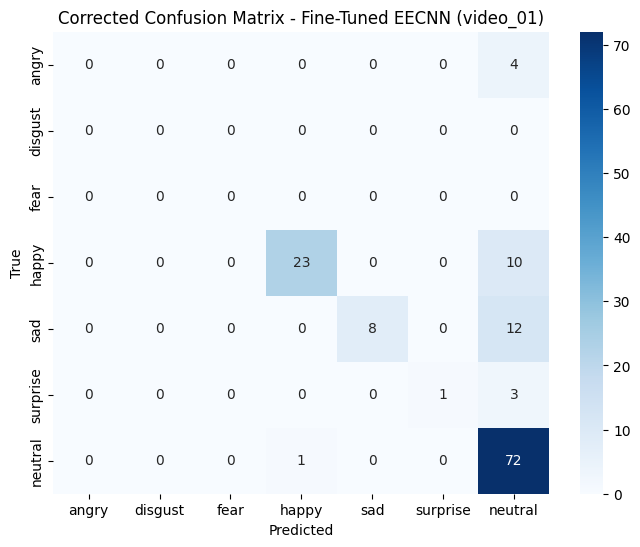

In [ ]:
cm = confusion_matrix(all_true, all_pred, labels=list(range(7)))

plt.figure(figsize=(8,6))
sns.heatmap(
    cm, annot=True, cmap="Blues", fmt="d",
    xticklabels=EMOTIONS,
    yticklabels=EMOTIONS
)
plt.title("Corrected Confusion Matrix - Fine-Tuned EECNN (video_01)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()
